## WEEK 2 — SUPERVISED LEARNING (CLASSIFICATION)

## Model By mahnoor khan

In [6]:
!pip install shap


   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/549.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/549.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/549.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/549.1 kB ? eta -:--:--
   -------------------------------------- 549.1/549.1 kB 400.5 kB/s eta 0:00:00

   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]



In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# ✅ Correct SHAP import
import shap


## 1. Load dataset

In [9]:
df = pd.read_csv("diabetes.csv")
print("Shape:", df.shape)
display(df.head())

Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


##  2. EDA (Replace invalid zeros with NaN)

In [10]:
cols_with_zero_invalid = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[cols_with_zero_invalid] = df[cols_with_zero_invalid].replace(0, np.nan)

# Check missing values
print("\nMissing values before imputation:\n", df.isnull().sum())



Missing values before imputation:
 Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


###  3. Impute missing values

In [11]:
imputer = SimpleImputer(strategy="median")
df[cols_with_zero_invalid] = imputer.fit_transform(df[cols_with_zero_invalid])

print("\nMissing values after imputation:\n", df.isnull().sum())


Missing values after imputation:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


### 4. Split data

In [12]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Baseline Model: Logistic Regression

In [14]:
log_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model.fit(X_train_scaled, y_train)

y_pred_log = log_model.predict(X_test_scaled)
print("\nLogistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Logistic Regression Accuracy: 0.7337662337662337
              precision    recall  f1-score   support

           0       0.82      0.75      0.79       100
           1       0.60      0.70      0.65        54

    accuracy                           0.73       154
   macro avg       0.71      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154



In [15]:
# Cross-validation
log_cv_scores = cross_val_score(log_model, scaler.transform(X), y, cv=5)
print("Logistic Regression CV Accuracy:", log_cv_scores.mean())


Logistic Regression CV Accuracy: 0.7579152873270519


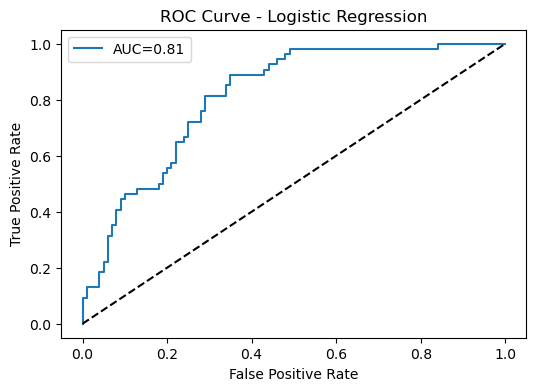

In [16]:
# ROC Curve
y_proba = log_model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={auc(fpr, tpr):.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

## 6.  Improved Model: Random Forest

In [17]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))



Random Forest Accuracy: 0.7402597402597403
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       100
           1       0.65      0.56      0.60        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.74      0.73       154



## 7.  Confusion Matrix (Random Forest)

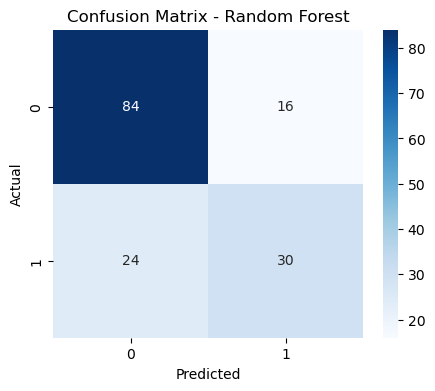

In [18]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 8. Feature Importance (Random Forest)

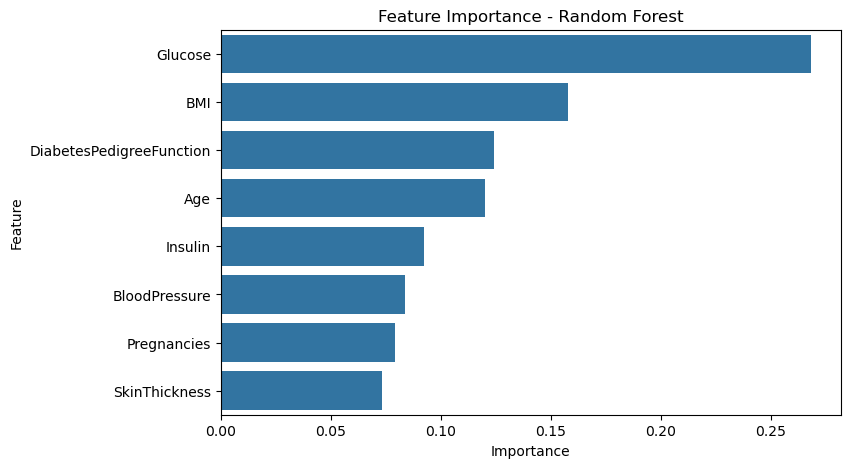

In [19]:
importances = rf.feature_importances_
feat_imp = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=feat_imp)
plt.title("Feature Importance - Random Forest")
plt.show()

## 9. SHAP Explanation (Random Forest)

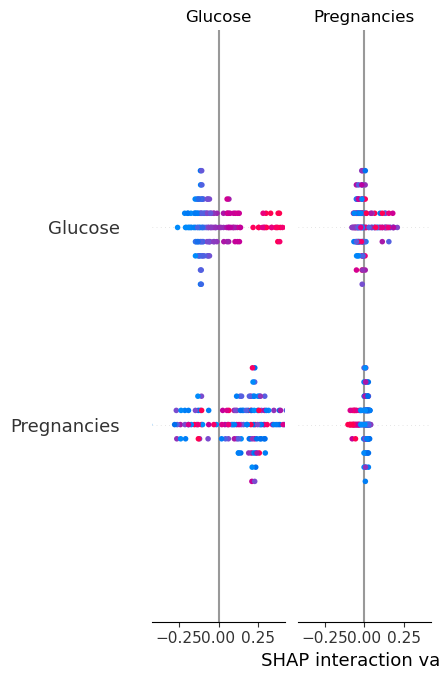

In [21]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_test)   

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

print("""
## Conclusion
- Supervised classification pipeline implemented successfully.
- Improved model chosen: Random Forest.
- Key features and model behavior interpreted with SHAP.
- Task objectives achieved.

**Model by Sharif Ullah**
""")
